In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc
import squidpy as sq

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_fluo_image_crop()
adata = sq.datasets.visium_fluo_adata_crop()

/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to en

squidpy==1.6.5


/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 303M/303M [00:24<00:00, 12.8MB/s] 
100%|██████████| 65.5M/65.5M [00:09<00:00, 6.96MB/s]


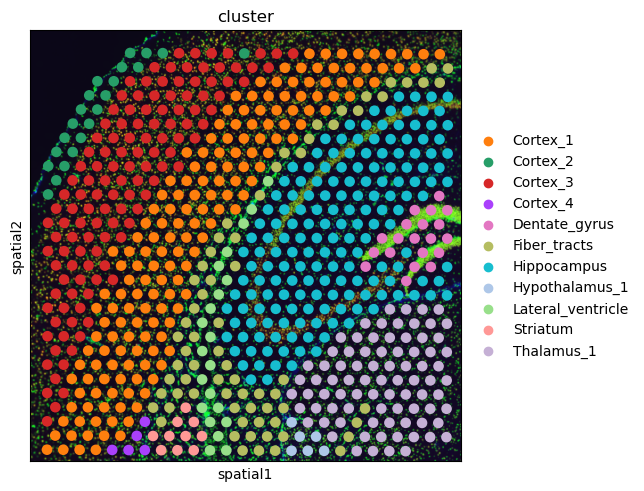

In [2]:
sq.pl.spatial_scatter(adata, color="cluster")

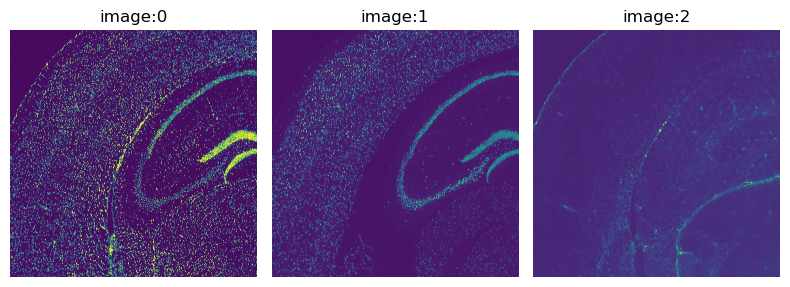

In [3]:
img.show(channelwise=True)

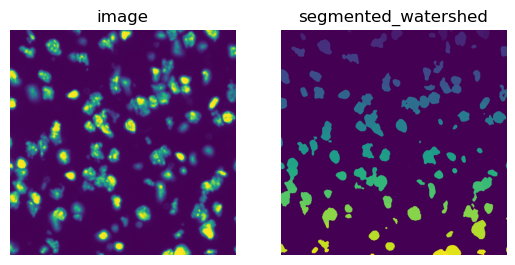

In [4]:
sq.im.process(
    img=img,
    layer="image",
    method="smooth",
)

sq.im.segment(img=img, layer="image_smooth", method="watershed", channel=0, chunks=1000)

# plot the resulting segmentation
fig, ax = plt.subplots(1, 2)
img_crop = img.crop_corner(2000, 2000, size=500)
img_crop.show(layer="image", channel=0, ax=ax[0])
img_crop.show(
    layer="segmented_watershed",
    channel=0,
    ax=ax[1],
)

  0%|          | 0/704 [00:00<?, ?/s]/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from annd

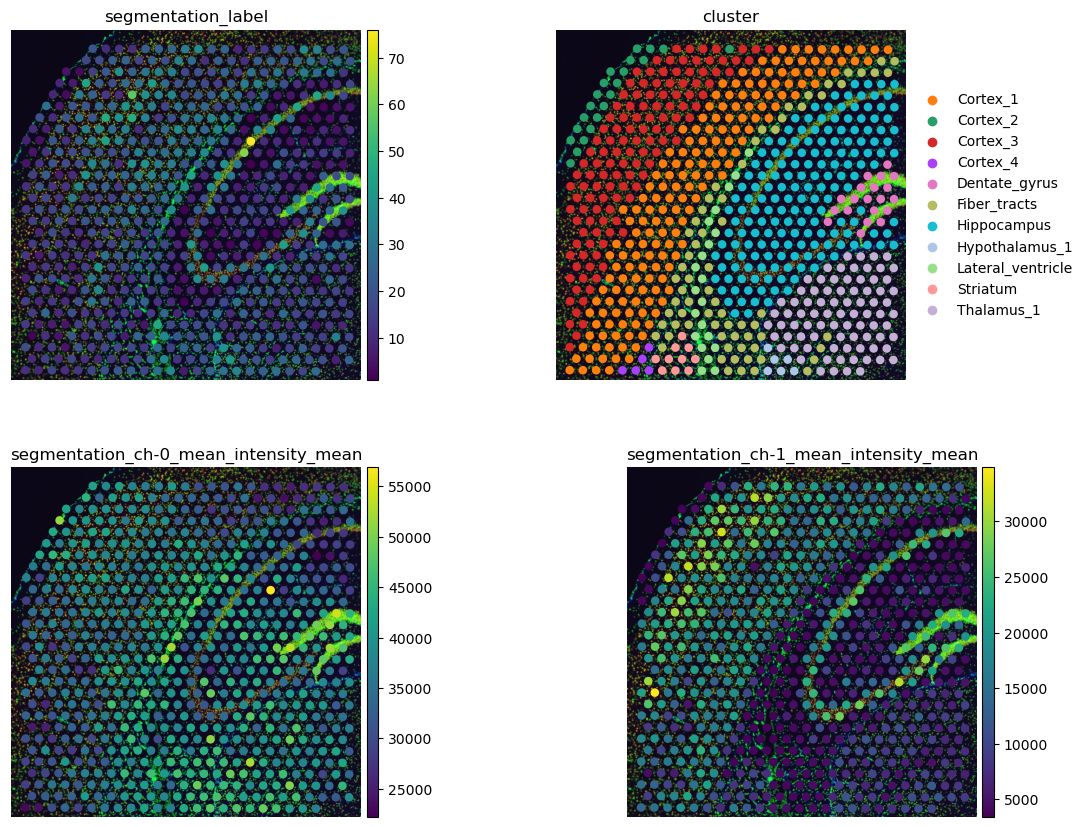

In [5]:
# define image layer to use for segmentation
features_kwargs = {"segmentation": {"label_layer": "segmented_watershed"}}
# calculate segmentation features
sq.im.calculate_image_features(
    adata,
    img,
    features="segmentation",
    layer="image",
    key_added="features_segmentation",
    n_jobs=1,
    features_kwargs=features_kwargs,
)
# plot results and compare with gene-space clustering
sq.pl.spatial_scatter(
    sq.pl.extract(adata, "features_segmentation"),
    color=[
        "segmentation_label",
        "cluster",
        "segmentation_ch-0_mean_intensity_mean",
        "segmentation_ch-1_mean_intensity_mean",
    ],
    frameon=False,
    ncols=2,
)

In [6]:
# define different feature calculation combinations
params = {
    # all features, corresponding only to tissue underneath spot
    "features_orig": {
        "features": ["summary", "texture", "histogram"],
        "scale": 1.0,
        "mask_circle": True,
    },
    # summary and histogram features with a bit more context, original resolution
    "features_context": {"features": ["summary", "histogram"], "scale": 1.0},
    # summary and histogram features with more context and at lower resolution
    "features_lowres": {"features": ["summary", "histogram"], "scale": 0.25},
}

for feature_name, cur_params in params.items():
    # features will be saved in `adata.obsm[feature_name]`
    sq.im.calculate_image_features(
        adata, img, layer="image", key_added=feature_name, n_jobs=1, **cur_params
    )

# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in params.keys()], axis="columns"
)

# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(
    adata.obsm["features"].columns
)

  0%|          | 0/704 [00:00<?, ?/s]/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from annd

In [7]:
def cluster_features(features: pd.DataFrame, like=None):
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]

/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/opt/anaconda3/envs/spa_marker/lib/python3.12/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/var/folders/np/ym8qscs97x38jk22s8r1phxr0000gn/T/ipykernel_73903/1102943926.py:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata

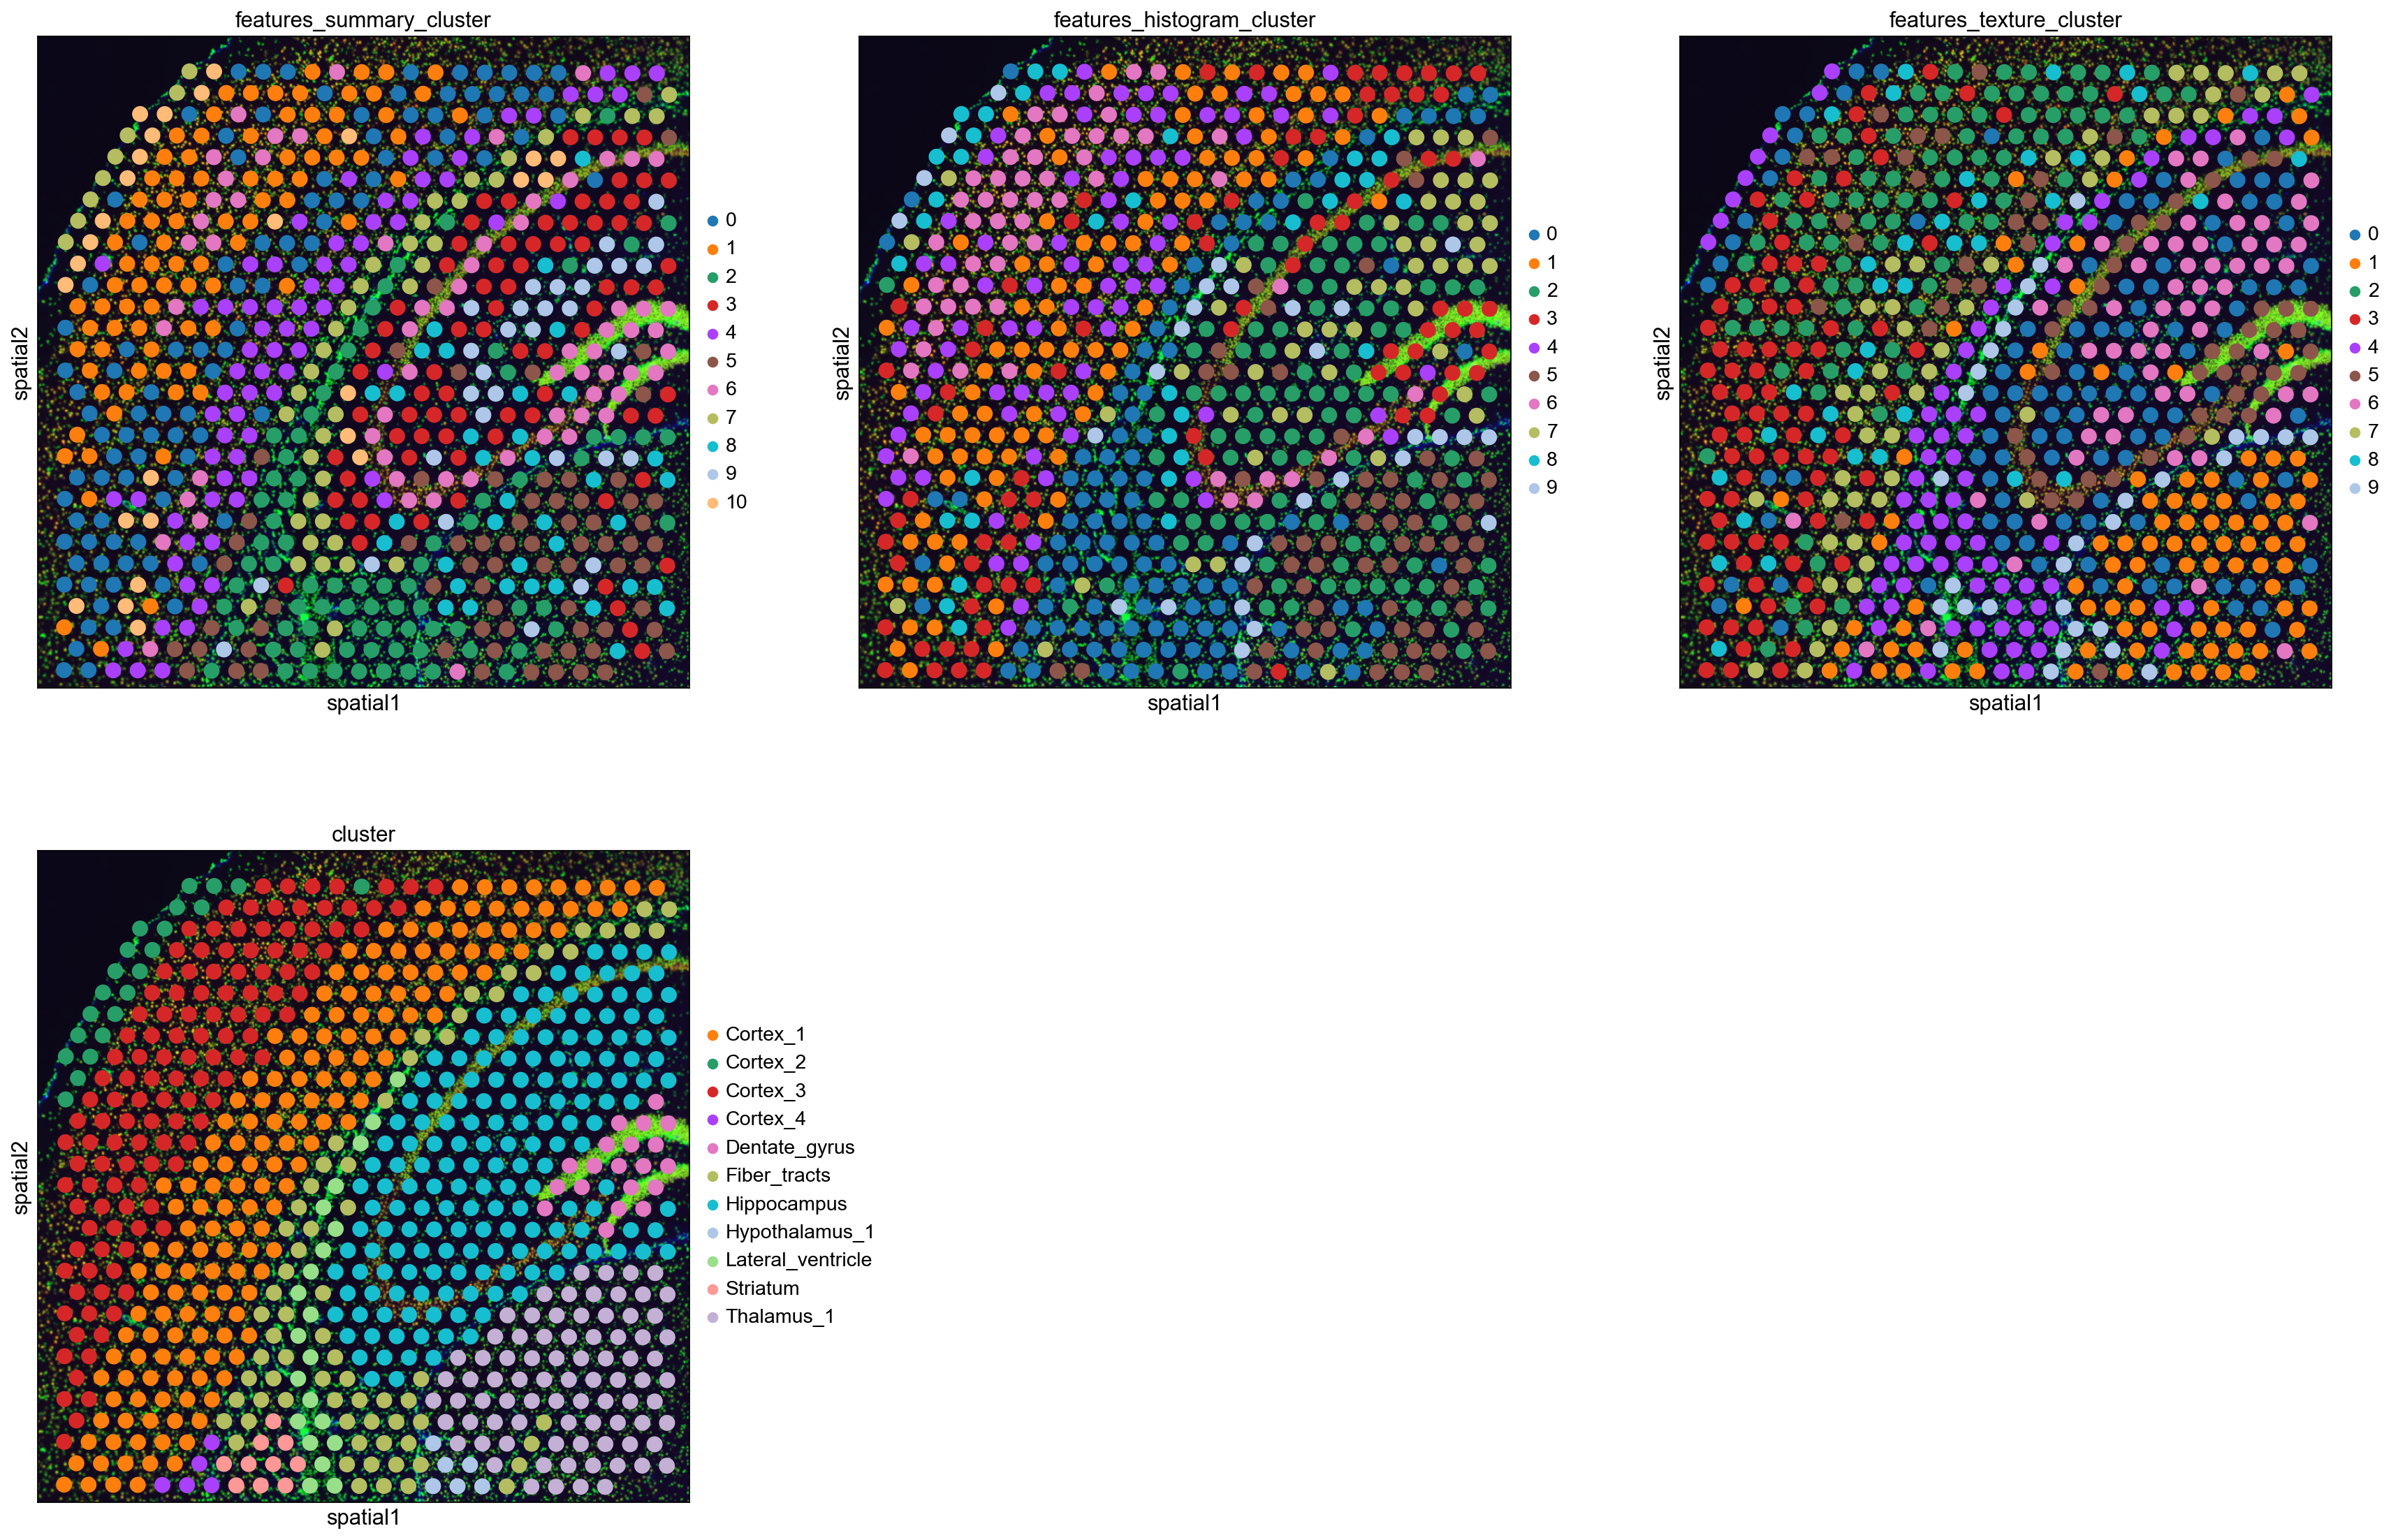

In [8]:
adata.obs["features_summary_cluster"] = cluster_features(
    adata.obsm["features"], like="summary"
)
adata.obs["features_histogram_cluster"] = cluster_features(
    adata.obsm["features"], like="histogram"
)
adata.obs["features_texture_cluster"] = cluster_features(
    adata.obsm["features"], like="texture"
)

sc.set_figure_params(facecolor="white", figsize=(8, 8))
sq.pl.spatial_scatter(
    adata,
    color=[
        "features_summary_cluster",
        "features_histogram_cluster",
        "features_texture_cluster",
        "cluster",
    ],
    ncols=3,
)